In [2]:
from typing import Union, List
import networkx as nx
import pandas as pd
import math
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout
from abc import ABC, abstractmethod
import numpy as np

In [4]:
def V(num) -> int:
    return int(4*num+1)

def S(num) -> int:
    return int(2*num+1)

def fG(num) -> int:
    return int(2*num-1)

def getType(num):
    if (num+1) %3 == 0:
        return "A"
    elif (num%3) == 0:
        return "B"
    elif (num-1)%3 == 0:
        return "C"

In [6]:
class Tree:
    def __init__(self, num_rows):
        self.num_rows = num_rows
        self.rows = []
        self.generate()
 
    def generate(self):
        for i in range(self.num_rows):
            row = []
            for j in range(2**i, 2**(i+1)):
                if j % 2 is 1:
                    node = Node(j)
                    row.append(node)
            self.rows.append(row)
   
    def getNode(self, label):
        row = Node.getRow(label)
        if row < self.num_rows:
            return self.rows[row][(label-(2**row+1))//2]
        return None
 
    def getGeom(self) -> Union[List[int], List[int], List[str]]:
        arr_x = []
        arr_y = []
        arr_colors = []
        for i, row in enumerate(self.rows):
            for j, node in enumerate(row):
                row_half = len(row) / 2
                x = 0.5 if (row_half < 1) else j-row_half+1
                arr_x.append(x)
                arr_y.append(i)
                color = "orange" 
                if node.state == NodeState.ORANGE:
                    color = "orange"
                elif node.state == NodeState.BLUE:
                    color = "blue" 
                else:
                    color = "black"
                
                
                arr_colors.append(color)
                if node.state == NodeState.BLACK:
                    rowIsMarked = False
        return arr_x, arr_y, arr_colors
   
    def mark(self, label):
        node = self.getNode(label)
        if node is not None:
            node.state = NodeState.ORANGE
    
    def freeze(self, label):
        node = self.getNode(label)
        if node is not None:
            node.state = NodeState.BLUE

    def checkRowMarked(self, lower_bound=0) -> int:
        rows_to_iterate = self.rows if lower_bound > 0 else reversed(self.rows)
        for i, row in enumerate(rows_to_iterate, start=lower_bound):
            rowIsMarked = True
            for node in row:
                if node.state == NodeState.BLACK:
                    rowIsMarked = False
                    break
            if rowIsMarked == True:
                return i
        return -1
   
    def countMarkedNodesAboveRow(self, row) -> int:
        cnt = 0
        for row in self.rows[row+1:]:
            for node in row:
                if node.state == NodeState.ORANGE:
                    cnt += 1
        return cnt

class NodeState():    
    BLACK = 1
    ORANGE = 2
    BLUE = 3


class Node:
    def __init__(self, label):
        self.tree = None
        self.row = Node.getRow(label)
        self.state = NodeState.BLACK
        self.label = label
   
    @staticmethod
    def getRow(label: int) -> int:
        return int(math.log(label,2))
 
    def setTree(self, tree: Tree):
        self.tree = tree
 
    @staticmethod
    def getType(label):
        if (label + 1) % 3 == 0:
            if ((label-1)/4)%2 == 0:
                return 4
            return 1
        elif label % 3 == 0:
            return 2
        elif (label - 1) % 3 == 0:
            return 3
        return -1

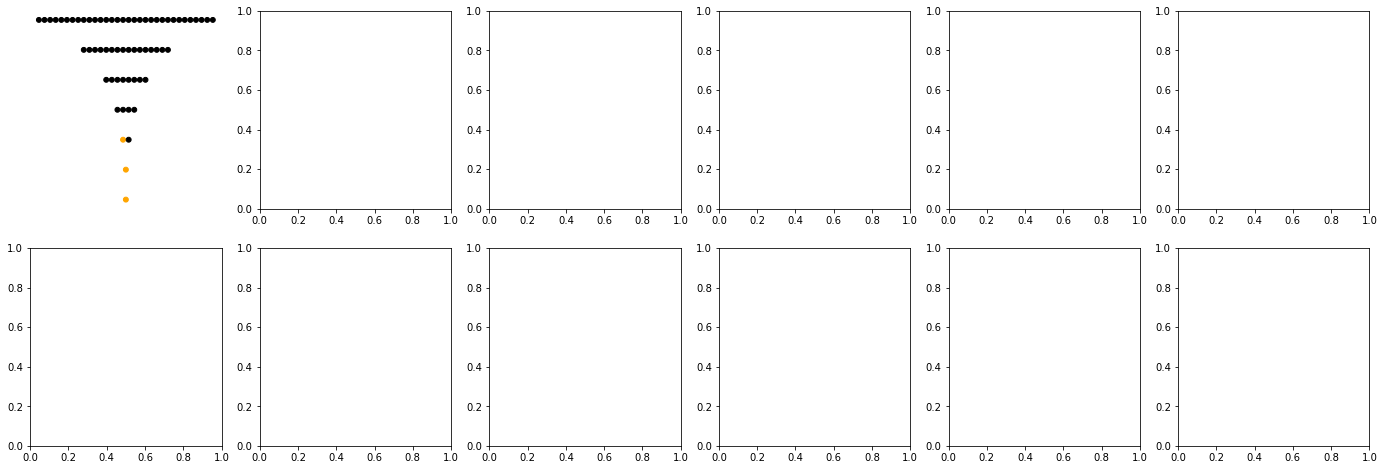

Empty DataFrame
Columns: [row, expense]
Index: []


In [8]:
def add_subplot(ax, ax_idx: int, tree):
    x, y, colors = tree.getGeom()
    ax[ax_idx].axis('off')
    ax[ax_idx].scatter(x, y, s=24, c=colors)

n = 7
tree = Tree(n)
tree.mark(1)
tree.mark(3)
tree.mark(5)

subplot_size = 4
subplot_cols = 6
subplot_rows = n//subplot_cols + 1
fig, ax = plt.subplots(subplot_rows, subplot_cols, figsize=(subplot_size*subplot_cols, subplot_size*subplot_rows))
ax = ax.flatten()
x, y, colors = tree.getGeom()
ax[0].axis('off')
ax[0].scatter(x, y, s=24, c=colors)

expenses = []
last_marked_row = 1
for i in range(3, 2**n, 2):
    node = tree.getNode(i)
    if node.state == NodeState.ORANGE:
        # RULE 1 : if x is orange V(x) becomes orange
        tree.mark(V(i))
        new_marked_row = tree.checkRowMarked(last_marked_row)
        if new_marked_row > last_marked_row:
            expenses.append([Node.getRow(i), tree.countMarkedNodesAboveRow(new_marked_row)])
            add_subplot(ax, last_marked_row)
            last_marked_row = new_marked_row

        # RULE 2 : if x is orange S(x) becomes orange (under the precise conditions of rule 2)
        #if (i-1)%4 == 0:
        #    if ((i-1)/4)%2 == 0:
        #        tree.mark(S(V(i)))
        
        tree.mark(S(i))
        new_marked_row = tree.checkRowMarked(last_marked_row)
        if new_marked_row > last_marked_row:
            expenses.append([Node.getRow(i), tree.countMarkedNodesAboveRow(new_marked_row)])
            add_subplot(ax, last_marked_row)
            last_marked_row = new_marked_row

        # RULE 3 : if x is orange and of type C then (4x/3)-1 becomes orange
        if Node.getType(i) == 3:
            tree.mark(int(4*i/3)-1)
            new_marked_row = tree.checkRowMarked(last_marked_row)
            if new_marked_row > last_marked_row:
                expenses.append([Node.getRow(i), tree.countMarkedNodesAboveRow(new_marked_row)])
                add_subplot(ax, last_marked_row)
                last_marked_row = new_marked_row

        # RULE 4 : if x is orange and of type A then G(x)/3 becomes orange
        if Node.getType(i) == 1:
            tree.mark(int(fG(i)/3))
            new_marked_row = tree.checkRowMarked(last_marked_row)
            if new_marked_row > last_marked_row:
                expenses.append([Node.getRow(i), tree.countMarkedNodesAboveRow(new_marked_row)])
                add_subplot(ax, last_marked_row)
                last_marked_row = new_marked_row

    node.state = NodeState.BLUE

plt.show()
df = pd.DataFrame(expenses, columns = ['row', 'expense'])
print(df[0:10])
